In [1]:
from gensim.models import KeyedVectors

# Load vectors directly from the Google file 
embeddingWords = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [33]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.tokenize import word_tokenize
from gensim import models
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import language_check
import seaborn as sn
from nltk.stem import WordNetLemmatizer

df_train = pd.read_csv('TrainingTwitterFinal20K.csv')
df_train.dropna(axis=0, inplace=True)

def clean(text):
    if type(text) != str or text == '':
        return ''

    text = re.sub("\"", " ", text)
    text = re.sub(",", " ", text)
    
    text = re.sub("  ", " ", text)
    text = re.sub("-", " ", text)
    
    text = re.sub("\'s", " is", text)
    text = re.sub(" whats ", "what is", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have", text)
    text = re.sub("can\'t", "cannot", text, flags=re.IGNORECASE)
    text = re.sub("don\'t", "do not", text, flags=re.IGNORECASE)
    text = re.sub("what\'s", "what is", text, flags=re.IGNORECASE)
    text = re.sub("aren\'t", "are not", text, flags=re.IGNORECASE)
    text = re.sub("it\'s", "it is", text, flags=re.IGNORECASE)
    text = re.sub("dont", "do not", text, flags=re.IGNORECASE)
    text = re.sub("how\'s'", "how is", text, flags=re.IGNORECASE)
    text = re.sub("isn\'t", "is not", text, flags=re.IGNORECASE)
    text = re.sub("jrk", "jerk", text, flags=re.IGNORECASE)
    text = re.sub("shoulda", "should have", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are", text, flags=re.IGNORECASE)
    text = re.sub("\'m", " am", text, flags=re.IGNORECASE)
    
    '''
    text = re.sub("\(", "", text)
    text = re.sub("\)", "", text)
    text = re.sub(":", "", text)
    text = re.sub("\?", "", text)
    text = re.sub("\.", "", text)
    text = re.sub("/", " ", text)
    
    text = re.sub(":\)", "", text)
    text = re.sub(":\(", "", text)
    text = re.sub(";\)", "", text)
    text = re.sub("\(;", "", text)
    text = re.sub(":,\(", "", text)
    text = re.sub("\(:", "", text)
    text = re.sub("\):", "", text)
    text = re.sub(":D", "", text)
    text = re.sub(":P", "", text)
    '''
    
    text = re.sub("aaaa", "aa", text, flags=re.IGNORECASE)
    text = re.sub("aaa", "aa", text, flags=re.IGNORECASE)
    text = re.sub("iii", "ii", text, flags=re.IGNORECASE)
    text = re.sub("ssss", "ss", text, flags=re.IGNORECASE)
    text = re.sub("uuu", "uu", text, flags=re.IGNORECASE)
    
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    

    text = re.sub(r"@\S+", '', text, flags=re.IGNORECASE)
    text = re.sub(r'\W+', ' ', text, flags=re.IGNORECASE)

    
    # remove stopwords
    stopWords = set(stopwords.words('english'))
    
    text_file = open("list.txt", "r")
    lines = text_file.readlines()
    lines = re.sub('"', '', lines[0])
    lines = re.sub(' ', '', lines)
    lines = re.sub('\n', '', lines)
    stopWords2 = lines.split(',')

    words = word_tokenize(text)
    wordsFiltered = []
    
    '''
    # lemmatizer
    lemmatizer = WordNetLemmatizer()
    for w in words:
        if w not in stopWords:
            if w not in stopWords2:
                wordsFiltered.append(lemmatizer.lemmatize(w))
    '''
    #stemmer
    stemmer = EnglishStemmer()
    for w in words:
        if w not in stopWords:
            if w not in stopWords2:
                wordsFiltered.append(stemmer.stem(w))
    
    
    
    # Return a list of words
    return sorted(list(set(wordsFiltered)))

In [34]:
df_train['comment'] = df_train['comment'].apply(clean)

In [35]:
#sum the vectors given a certain size
def sumvector(vec1, vec2 ,size):
    if vec1 is None:
        vec1 = [0] * size
    if vec2 is None:
        vec2 = [0] * size

    vecsum = []
    for i in range(len(vec1)):
        vecsum.append(vec1[i] + vec2[i])

    return vecsum

In [48]:
#get values from the train data
c1 = df_train['comment'].values.tolist()
c2 = df_train2['comment'].values.tolist()

c3 = c1 + c2
#create a model using word2vec algorithm using the train data
model = models.Word2Vec(c3, min_count=1, size=128)

#create the vectors of each sentence
C_vectors = [None] * 21704
sizeVect= 10

count = 0
for i, sentence in enumerate(df_train['comment']):

    for j, sentence2 in enumerate(df_train['comment'][i]):
        
        if df_train['comment'][i][j] in embeddingWords.vocab:
            C_vectors[i] = sumvector(C_vectors[i], embeddingWords[df_train['comment'][i][j]], sizeVect)
        else:
            C_vectors[i] = sumvector(C_vectors[i], model.wv[df_train['comment'][i][j]], sizeVect)
    
    if C_vectors[i] is None:
        C_vectors[i] = [0] * 10
    count = i + 1

for i, sentence in enumerate(df_train2['comment']):

    for j, sentence2 in enumerate(df_train2['comment'][i]):
        
        if df_train2['comment'][i][j] in embeddingWords.vocab:
            C_vectors[count + i] = sumvector(C_vectors[count + i], embeddingWords[df_train2['comment'][i][j]], sizeVect)
        else:
            C_vectors[count + i] = sumvector(C_vectors[count + i], model.wv[df_train2['comment'][i][j]], sizeVect)
    
    if C_vectors[count + i] is None:
        C_vectors[count + i] = [0] * 10 


#create a classifier Support vector machines
#SvmClass = svm.SVC(gamma="scale", C = 1.6) #50k
SvmClass = svm.SVC(gamma="scale", C = 2.00) #20k
#SvmClass = svm.SVC(gamma="scale", C = 1.40) #100k

In [49]:
#label the training set data
labels = (df_train['positivity'].values.tolist() + df_train2['positivity'].values.tolist())

SvmClass.fit(C_vectors, labels)

SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
#prepare test set of plug it in to the classifier
df_test = pd.read_csv('200RCnew2.csv', error_bad_lines=False)

df_test['comment'] = df_test['comment'].apply(clean)

#get values from the test data
T1 = df_test['comment'].values.tolist()
#create a model using word2vec algorithm using the train data
modelTest = models.Word2Vec(T1, min_count=1, size=10)

#compute labels for the test data
labels = df_test['positivity'].values

#create the vectors of each sentences
C_vectors2 = [None] * 200

for i, sentence in enumerate(df_test['comment']):
    for j, sentence2 in enumerate(df_test['comment'][i]):
        
        if df_test['comment'][i][j] in embeddingWords.vocab:
            C_vectors2[i] = sumvector(C_vectors2[i], embeddingWords[df_test['comment'][i][j]], sizeVect)
        else:
            C_vectors2[i] = sumvector(C_vectors2[i], modelTest.wv[df_test['comment'][i][j]], sizeVect)
    
    if C_vectors[i] is None:
        C_vectors[i] = [0] * 10

# calculate accuracy of the classifier
predicted = SvmClass.predict(C_vectors2)

print(np.mean(predicted == labels))

0.62


In [51]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    classes = ('Negative', 'Positive')
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


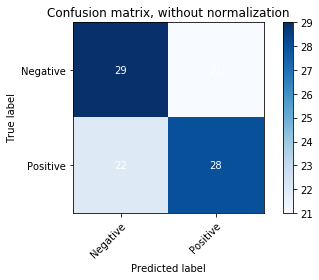

In [52]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, predicted, title='Confusion matrix, without normalization')

plt.show()

Evaluate the quality of the output of a classifier. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without normalization by class support size (number of elements in each class). This kind of normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified.